In [40]:
import tensorflow as tf
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import os
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from pathlib import Path
from PIL import Image
import comet_ml
import time
from dotenv import load_dotenv

The goal of this dataset should be:
- Autoencoder should be able to reconstruct normal images accurately
- Normal images should have low reconstruction error
- Tumor images should have high reconstruction error since model wasn't trained on them
- The threshold should be able to classify images as anomalous if its loss is higher than threshold

In [41]:
# Check if GPU is enabled
print(tf.config.list_physical_devices("GPU"))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [42]:
load_dotenv()
api_key = os.getenv("COMET_API_KEY")
comet_ml.login(api_key=api_key)

COMET INFO: Valid Comet API Key saved in C:\Users\tommy\.comet.config (set COMET_CONFIG to change where it is saved).


In [43]:
experiment = comet_ml.start(
    project_name="brain-anomaly-autoencoder",
    experiment_config=comet_ml.ExperimentConfig(
        auto_histogram_weight_logging=True,
        auto_histogram_gradient_logging=True,
        auto_histogram_activation_logging=True,
    ),
)

COMET INFO: An experiment with the same configuration options is already running and will be reused.


### Inspect Dataset

In [44]:
# Download dataset from kaggle
# Link: https://www.kaggle.com/datasets/murtozalikhon/brain-tumor-multimodal-image-ct-and-mri
# path = kagglehub.dataset_download("murtozalikhon/brain-tumor-multimodal-image-ct-and-mri")

In [45]:
# Path for dataset
DATASET_PATH = Path("archive/Dataset")

# Define path for healthy and tumor folders
MRI_PATH = DATASET_PATH / "Brain Tumor MRI Images"
MRI_HEALTHY_PATH = MRI_PATH / "Healthy"
MRI_TUMOR_PATH = MRI_PATH / "Tumor"

In [46]:
# Inspect how many images are in each folder
print(f'Number of Healthy Brain MRI Scans: {len(list(MRI_HEALTHY_PATH.glob("*")))}')
print(f'Number of Tumor Brain MRI Scans: {len(list(MRI_TUMOR_PATH.glob("*")))}')

Number of Healthy Brain MRI Scans: 2000
Number of Tumor Brain MRI Scans: 3000


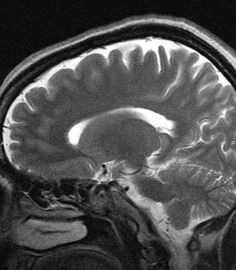

In [47]:
# Show random healthy brain MRI image
healthy_images = list(MRI_HEALTHY_PATH.glob("*"))
rand_index_healthy = np.random.randint(len(healthy_images))

Image.open(healthy_images[rand_index_healthy])

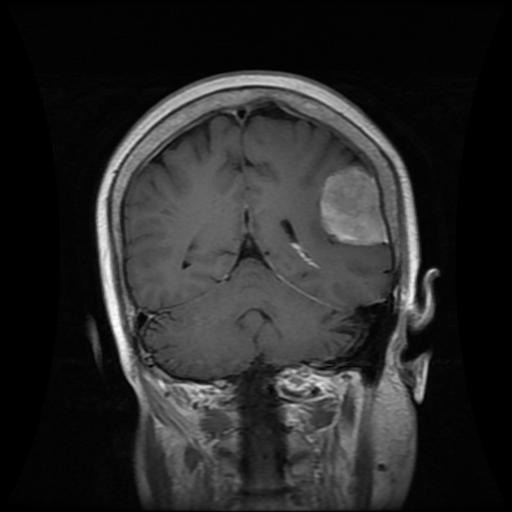

In [48]:
# Show random brain tumor MRI image
tumor_images = list(MRI_TUMOR_PATH.glob("*"))
rand_index_tumor = np.random.randint(len(tumor_images))

Image.open(tumor_images[rand_index_tumor])

### Preprocess Images

In [49]:
IMAGE_SIZE = (128, 128)

In [50]:
# Normalizes pixel values of an image between [0, 1]
def normalize(image):
    return image / 255.0

In [51]:
# Resizes image based on given height and width dimension
def resize(input_image, height, width):
    return tf.image.resize(
        images = input_image,
        size = [height, width],
        method = tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )

In [52]:
def preprocess_img(img_path, height=128, width=128):
    # Read file from file path
    image = tf.io.read_file(img_path)

    # https://www.tensorflow.org/api_docs/python/tf/io/decode_image
    # "Note: decode_gif returns a 4-D array [num_frames, height, width, 3], as opposed to decode_bmp, 
    # decode_jpeg and decode_png, which return 3-D arrays [height, width, num_channels]."
    # set the expand_animations argument of this function to False, in which case the op will return 3-dimensional tensors 
    # and will truncate animated GIF files to the first frame.
    # Set channels to 1 so that every image is converted to grayscale
    image = tf.io.decode_image(image, expand_animations=False, channels=1)

    # Convert image to tensor
    image = tf.cast(image, dtype="float32")

    # Resize image
    image = resize(image, height, width)

    # Normalize pixels in image
    image = normalize(image)
    
    # Model expects data and labels; return image twice to fit model requirement
    return image, image

In [53]:
def show_image(image):
    # Display pixel value range
    print(f'[{np.min(image)}, {np.max(image)}]')

    # Display image shape
    print(f'Image shape: {image.shape}')
    plt.figure()
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # imshow shows images in color; specify "gray"
    plt.imshow(image, cmap="gray")
    plt.show()

[0.0, 1.0]
Image shape: (128, 128, 1)


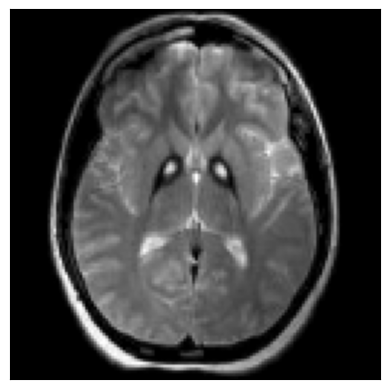

In [54]:
# Pass random image into preprocess function
rand_index_healthy = np.random.randint(len(healthy_images))
img, _ = preprocess_img(str(healthy_images[rand_index_healthy]))

show_image(img)

[0.0, 0.9647058844566345]
Image shape: (128, 128, 1)


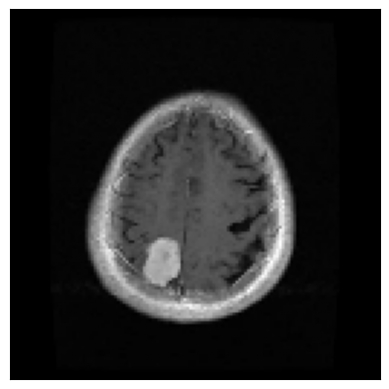

In [55]:
rand_index_tumor = np.random.randint(len(tumor_images))
img, _ = preprocess_img(str(tumor_images[rand_index_tumor]))

show_image(img)

### Build Train, Test, and Validation Dataset

In [56]:
BATCH_SIZE = 64
BUFFER_SIZE = len(healthy_images)

In [57]:
healthy_dataset = tf.data.Dataset.list_files(str(MRI_HEALTHY_PATH / "*"))

healthy_dataset = healthy_dataset.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
healthy_dataset = healthy_dataset.shuffle(BUFFER_SIZE).prefetch(tf.data.AUTOTUNE)

tumor_dataset = tf.data.Dataset.list_files(str(MRI_TUMOR_PATH / "*"))

# No shuffling for tumor dataset as this will be test dataset
tumor_dataset = tumor_dataset.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
tumor_dataset = tumor_dataset.prefetch(tf.data.AUTOTUNE)

In [58]:
# Link: https://stackoverflow.com/questions/48213766/split-a-dataset-created-by-tensorflow-dataset-api-in-to-train-and-test
# Split dataset into sections

# Testing data that comprises only of normal images to establish threshold value (200 images)
# 400 images are taken because half of it will be used for validation
normal_test_data = healthy_dataset.take(400)

# Train data that comprises only of normal images (1600 images)
normal_train_data = healthy_dataset.skip(400)

# 200 images for validation for creating threshold; the rest (200) for test
normal_valid_data = normal_test_data.take(200)
normal_test_data = normal_test_data.skip(200)

# Combine images from normal and tumor dataset to form one validation dataset (200 + 200)
tumor_valid_data = tumor_dataset.take(200)
valid_data = normal_valid_data.concatenate(tumor_valid_data)

# Take 200 images from tumor dataset for testing; the rest is saved for evaluating threshold on just tumor images
tumor_dataset = tumor_dataset.skip(200)
tumor_test_data = tumor_dataset.take(200)
tumor_dataset = tumor_dataset.skip(200)

# Testing data that has a mix of both normal and tumor images to evaluate threshold
test_dataset = normal_test_data.concatenate(tumor_test_data)

print(f'Normal test data size: {len(normal_test_data)}')
print(f'Normal train data size: {len(normal_train_data)}')
print(f'Validation data size: {len(valid_data)}')
print(f'Tumor dataset size: {len(tumor_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

normal_test_data = normal_test_data.batch(BATCH_SIZE)
normal_train_data = normal_train_data.batch(BATCH_SIZE)
normal_valid_data = normal_valid_data.batch(BATCH_SIZE)

# Shuffle validation set to ensure model doesn't learn neighboring patterns
valid_data = valid_data.shuffle(len(valid_data)).batch(BATCH_SIZE)

tumor_dataset = tumor_dataset.batch(BATCH_SIZE)
tumor_test_data = tumor_test_data.batch(BATCH_SIZE)

# Do not shuffle test dataset
test_dataset = test_dataset.batch(BATCH_SIZE)

Normal test data size: 200
Normal train data size: 1600
Validation data size: 400
Tumor dataset size: 2600
Test dataset size: 400


### Initialize Convolutional Autoencoder Model

In [59]:
class AnomalyCAE(Model):
    def __init__(self, latent_dim):
        super(AnomalyCAE, self).__init__()
        
        # Downsampling with CNN
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(128, 128, 1)),
            layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu"),
            layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu"),
            layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu"),
            layers.Flatten(),
            layers.Dropout(0.2),
            layers.Dense(latent_dim) # no activation to keep latent representations
        ])

        # Upsampling with CNN
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(units=16*16*128, activation="relu"),
            layers.Reshape(target_shape=(16, 16, 128)),
            layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu"),
            layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu"),
            
            # Filter must match color channel of original input
            layers.Conv2DTranspose(filters=1, kernel_size=(2, 2), strides=(2, 2), padding="same"),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded

latent_dim = 128
autoencoder = AnomalyCAE(latent_dim)

In [60]:
autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dropout (Dropout)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 128)               4194432   
                                                                 
Total params: 4,287,104
Trainable params: 4,287,104
Non-

In [61]:
autoencoder.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 32768)             4227072   
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 128)      147584    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 64, 64, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 128, 128, 1)      257       
 ranspose)                                                       
                                                      

### Train Autoencoder Model

In [62]:
autoencoder.compile(optimizer=optimizers.Adam(), loss=losses.MeanSquaredError())

In [63]:
# Monitors validation loss and stops training if valid loss doesn't improve past 3 epochs
# verbose=1 means that it will show a message when early stopping is done
cae_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, verbose=1)

cae_history = autoencoder.fit(
    normal_train_data,
    epochs=40,
    validation_data=valid_data,
    shuffle=True,
    callbacks=[cae_callback]
)

Epoch 1/40
25/25 [==============================] - 12s 120ms/step - loss: 0.0447 - val_loss: 0.0238
Epoch 2/40
25/25 [==============================] - 3s 93ms/step - loss: 0.0244 - val_loss: 0.0215
Epoch 3/40
25/25 [==============================] - 3s 97ms/step - loss: 0.0229 - val_loss: 0.0208
Epoch 4/40
25/25 [==============================] - 3s 80ms/step - loss: 0.0213 - val_loss: 0.0198
Epoch 5/40
25/25 [==============================] - 3s 111ms/step - loss: 0.0198 - val_loss: 0.0185
Epoch 6/40
25/25 [==============================] - 3s 83ms/step - loss: 0.0196 - val_loss: 0.0184
Epoch 7/40
25/25 [==============================] - 3s 79ms/step - loss: 0.0184 - val_loss: 0.0162
Epoch 8/40
25/25 [==============================] - 3s 87ms/step - loss: 0.0172 - val_loss: 0.0157
Epoch 9/40
25/25 [==============================] - 3s 82ms/step - loss: 0.0158 - val_loss: 0.0154
Epoch 10/40
25/25 [==============================] - 3s 108ms/step - loss: 0.0147 - val_loss: 0.0137
Epoch

### Plot Results

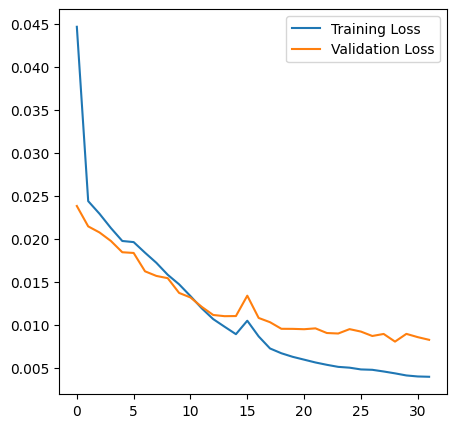

In [64]:
fig = plt.figure(figsize=(5, 5))
plt.plot(cae_history.history["loss"], label="Training Loss")
plt.plot(cae_history.history["val_loss"], label="Validation Loss")
plt.legend()

experiment.log_figure(fig)
plt.show()

In [65]:
def test_single_img(data):
    # Retrieve only one batch from dataset
    for batch in data.take(1):
        # Get first image from batch
        image = batch[0][0]

        # Insert batch dimension into image: (1, 128, 128, 1)
        encoded_data = autoencoder.encoder(tf.expand_dims(image, axis=0)).numpy()
        decoded_data = autoencoder.decoder(encoded_data).numpy()

        fig = plt.figure(figsize=(7, 7))

        plt.subplot(1, 2, 1)
        plt.imshow(image, cmap="gray")
        plt.title("Input Image")

        # Remove batch dimension for visualization
        plt.subplot(1, 2, 2)
        plt.imshow(decoded_data[0].squeeze(), cmap="gray")
        plt.title("Reconstructed Image")

        experiment.log_figure(fig)

        plt.show()

Healthy images that have been reconstructed should look similar to the original input because the model was trained on healthy images. The reconstructed image should have noise.

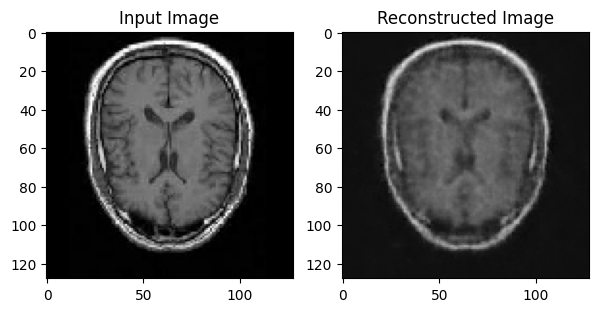

In [66]:
test_single_img(normal_train_data)

Tumorous images should have a tougher time being recreated by the autoencoder due to tumorous images not being used for training. These images should be unrecognizable.

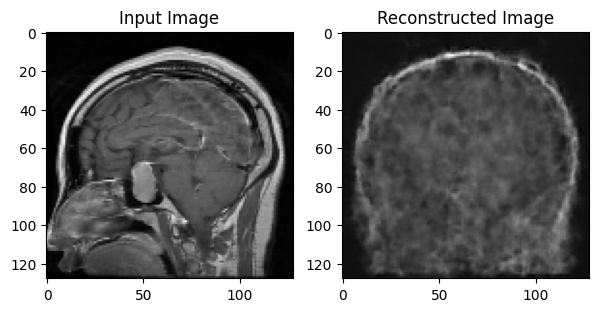

In [67]:
test_single_img(tumor_test_data)

### Test Model

In [68]:
def prediction(data):
    total_loss = []

    for batch in data.take(len(data)):
        reconstruction = autoencoder.predict(batch[0], verbose=0)
        train_loss = tf.keras.losses.mse(reconstruction, batch[0])

        # train_loss computes MSE for each pixel in an image so use reduce_mean()
        # to average over all pixels across all dimensions into a single value for each image 
        train_loss = tf.reduce_mean(train_loss, axis=(1, 2))

        # Append list into another list but keep it 1D
        total_loss.extend(train_loss)
    
    return total_loss

In [69]:
def show_distribution(loss, threshold=0, bins=60):
    fig = plt.figure(figsize=(7, 7))
    plt.hist(loss, bins=bins)
    plt.xlabel("loss")
    plt.ylabel("No of examples")

    if threshold > 0:
        plt.axvline(threshold, color='r', linestyle="--", label="threshold")

    experiment.log_figure(fig)
    
    plt.legend()
    plt.show()

C:\Users\tommy\AppData\Local\Temp\ipykernel_7868\1299287362.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


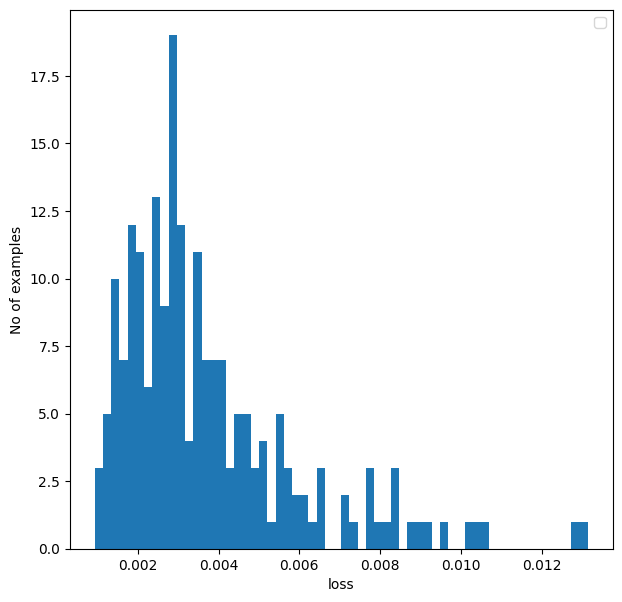

In [70]:
total_normal_loss = prediction(normal_valid_data)
show_distribution(total_normal_loss)

### Set Threshold

In [71]:
# Establish threshold 
threshold = np.mean(total_normal_loss) + np.std(total_normal_loss)
print(f'Threshold: {threshold}')

Threshold: 0.005944501608610153


### Compare Model Prediction to Threshold

In [72]:
# Returns a list of booleans on if each element in total_loss is less than the threshold
def get_predictions(total_loss, threshold, isNormal=True):
    if isNormal:
        # Loss less than the threshold means that it is normal
        return tf.math.less(total_loss, threshold)

    return tf.math.greater(total_loss, threshold)

In [73]:
# Display accuracy, precision, and recall score between model predictions and truth labels
def print_stats(predictions, labels):
    print(f'Accuracy: {accuracy_score(labels, predictions):.2f}')
    print(f'Precision: {precision_score(labels, predictions):.2f}')
    print(f'Recall: {recall_score(labels, predictions):.2f}')

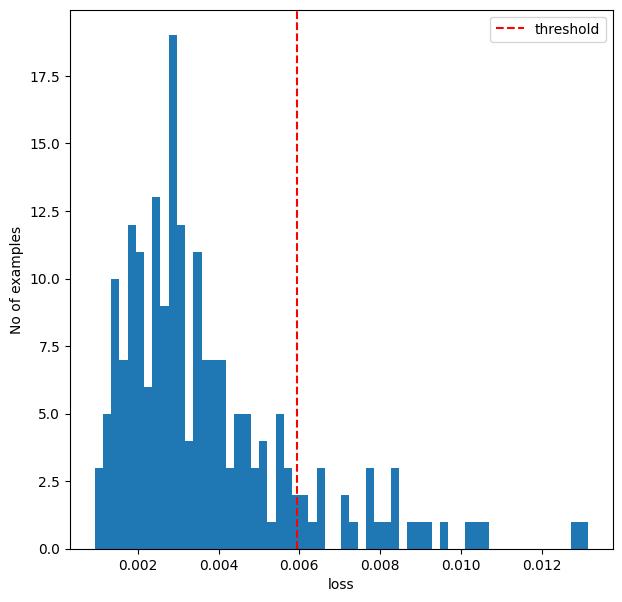

In [74]:
total_normal_test_loss = prediction(normal_test_data)

show_distribution(total_normal_loss, threshold)

Reconstruction error for anomalous images should be higher than reconstruction error for normal images. Autoencoder was trained purely on normal images.

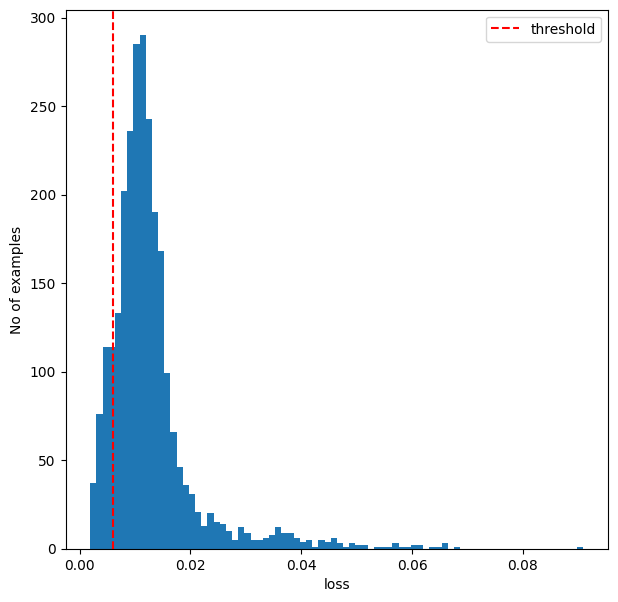

Accuracy: 0.89
Precision: 1.00
Recall: 0.89


In [75]:
total_tumor_test_loss = prediction(tumor_dataset)

tumor_test_predictions = get_predictions(total_tumor_test_loss, threshold, isNormal=False)

# Labels are all 0s because we ideally want our tumor test loss to be above the threshold
tumor_test_labels = [1 for i in range(len(total_tumor_test_loss))]

show_distribution(total_tumor_test_loss, threshold, bins=80)
print_stats(tumor_test_predictions, tumor_test_labels)

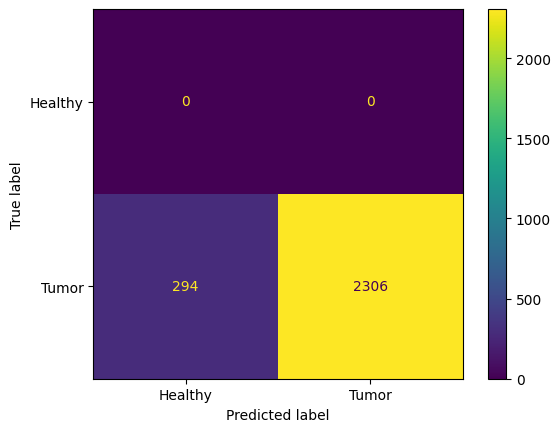

In [76]:
cm = confusion_matrix(tumor_test_labels, tumor_test_predictions)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "Tumor"])

cm_display.plot()

In [77]:
total_test_loss = prediction(test_dataset)

combined_test_predictions = get_predictions(total_test_loss, threshold)

# Because we are using tf.math.less, normal images get a 1 while abnormal get 0
# Test dataset is unshuffled; 1st half of dataset should be normal images and 2nd half is tumor images
combined_test_labels = [1 if i < len(total_test_loss) / 2 else 0 for i in range(len(total_test_loss))]

print_stats(combined_test_predictions, combined_test_labels)

Accuracy: 0.87
Precision: 0.89
Recall: 0.85


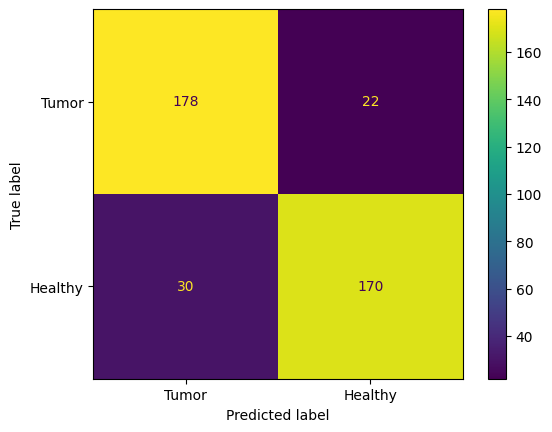

In [78]:
cm = confusion_matrix(combined_test_labels, combined_test_predictions)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Tumor", "Healthy"])

cm_display.plot()

By having a mix of normal and tumor images in our test dataset, we generate their reconstruction losses and we compare it to the threshold. This will generate the model's predictions and we are able to use this with our truth labels to see how well the threshold can distinguish between healthy and tumor images.

In [79]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : confidential_cucumber_3388
COMET INFO:     url                   : https://www.comet.com/tommy-long4358/brain-anomaly-autoencoder/b6b76663687843fb9e50d29568932067
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     figures                      : 6
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     git-patch (uncompressed)     : 1 (8.33 KB)
COMET INFO:     installed packages           : 1
COMET INFO:     noteb